In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as guide_positive, all others as guide_negative

In [6]:
mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "guide_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "guide_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
    }
    
    seurat_obj
}

### Load guide df

In [7]:
#df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [8]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [9]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [10]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 3

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 753

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

# Check DE for genes near SNPs

In [15]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [16]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210



In [17]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [18]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
if(any(select_distal)) {
    df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
    chr_and_coords = str_split(df_nors_snps$gene, "_")
    df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
    colnames(df_dummy) <- c("chr", "start")

    df_nors_snps$chr = paste0('chr', df_dummy$chr)
    df_nors_snps$start_position  = as.numeric(df_dummy$start)
    df_nors_snps$end_position    = as.numeric(df_dummy$start)
    df_nors_snps$strand          = "*"
    df_nors_snps$hgnc_symbol     = df_nors_snps$gene
    df_nors_snps$chromosome_name = df_dummy$chr

    select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
    df_nors_snps = df_nors_snps[, select_cols]
    df_snp_coords = rbind(df_snp_coords, df_nors_snps)
}

In [19]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [20]:
#searchDatasets(mart = ensembl, pattern = "hsapiens")
#mart <- useMart("ensembl")
#mart <- useDataset("hsapiens_gene_ensembl", mart)

# Find neighbors of targets

In [21]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
options(timeout=100000)
mart <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", mirror="useast")
#m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

Ensembl site unresponsive, trying www mirror



In [22]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=mart, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [23]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
TKT 3 52224712 54256052 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979488 8 29423114 31423114 
rs2661503 6 50644819 52644819 
rs10224210 7 150716108 152716108 


In [24]:
#list.save(neighbors_list, "/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")

### Q

# Run diffex on pseudobulked samples using DESeq2

In [25]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01


for(i in 1:nrow(df_targets)) {
    i = 28
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$psbulk_replicate_id = Idents(seurat_dummy)
    seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$psbulk_replicate_id, "_", seurat_dummy$donor)
    Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id

    counts <- AggregateExpression(
        seurat_dummy,            
        assays = 'RNA',
        slot = "counts",
        return.seurat = FALSE
    )
    #
    break
}


DE15 DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 2198 ; Guide- = 24944 


In [26]:
df_counts <- as.data.frame(counts$RNA)
df_counts <- df_counts[, sort(colnames(df_counts))]
head(df_counts, 20)

,guide_negative_0,guide_negative_1,guide_negative_2,guide_negative_3,guide_positive_0,guide_positive_1,guide_positive_2,guide_positive_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-2HG,1,0,0,2,0,0,0,1
FAM138A,0,0,0,0,0,0,0,0
OR4F5,1,1,0,4,0,0,0,0
AL627309.1,60,65,76,64,7,6,8,8
AL627309.3,4,3,3,1,0,1,3,0
AL627309.2,0,0,0,0,0,0,0,0
AL627309.5,63,100,119,74,7,8,12,7
AL627309.4,1,2,1,0,0,1,1,0
AP006222.2,0,0,1,1,0,0,0,0


In [27]:
col_data = data.frame(c(rep(c("Control"),4), rep(c("Stimulated"),4)))
rownames(col_data) = colnames(df_counts)
colnames(col_data) = "condition"
col_data

,condition
,<chr>
guide_negative_0,Control
guide_negative_1,Control
guide_negative_2,Control
guide_negative_3,Control
guide_positive_0,Stimulated
guide_positive_1,Stimulated
guide_positive_2,Stimulated
guide_positive_3,Stimulated


In [28]:
# Create DESeq2 object   
library(DESeq2)
dds <- DESeqDataSetFromMatrix(
    countData = df_counts,
    colData = col_data,
    design = ~ condition
)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count


The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCum

In [29]:
keep <- rowSums(counts(dds)) >=5
dds <- dds[keep,]

In [30]:
# run DESeq2
dds <- DESeq(dds, )

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



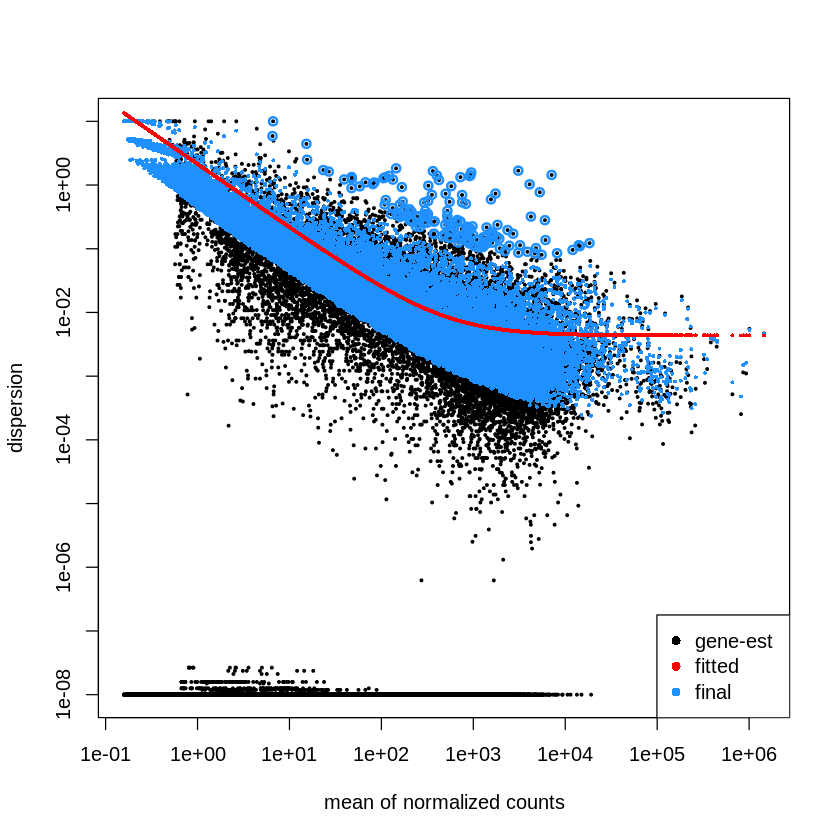

In [31]:
plotDispEsts(dds)

In [32]:
resultsNames(dds)

[1] "Intercept"                       "condition_Stimulated_vs_Control"

In [33]:
# Generate results object
#res <- results(dds, name = "condition_Stimulated_vs_Control")
res <- results(dds, contrast=c("condition","Control", "Stimulated"))
res

# Run diffex on pseudobulked samples using EdgeR

In [34]:
library(edgeR)

Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:DESeq2':

    plotMA


The following object is masked from 'package:BiocGenerics':

    plotMA




In [64]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01


for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
    #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'guide_positive')$donor) )

    counts <- AggregateExpression(
        seurat_dummy,            
        assays = 'RNA',
        slot = "counts",
        return.seurat = FALSE
    )
    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "guide_negative"] = 1
    cluster_list[cluster_list == "guide_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    table(keep.samples)
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
    table(keep.genes)
    y <- normLibSizes(y)

    # Create design matrix
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
    diag(contr) <- 1
    contr[1,] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))
    
    # Estimate dispersion
    y <- estimateDisp(y, design, robust=TRUE)
    y$common.dispersion

    # Fit
    fit <- glmQLFit(y, design, robust=TRUE)
    qlf <- glmQLFTest(fit, contrast=contr[,1])
    markers <- qlf$table[neighbors, ] %>% arrange(PValue)

    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(markers)
}


## Inpect DE results

Print top high-confidence hits

In [ ]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(10)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.37,6.9,1153,2.5e-226,ANPEP,ANPEP,tss,Control TSS
2,-0.76,4.8,129,1.2e-29,CCNB1,DE4,ckd_de,CKD DE
3,-0.34,8.3,126,4.0e-29,TKT,TKT,de_control,Control DE
4,-0.39,6.5,92,7.5e-22,PKHD1,DE16,ckd_de,CKD DE
5,-0.32,7.4,90,2.4e-21,AK5,FUBP1,tss,Control TSS
6,-0.47,5.5,85,3.8e-20,LOXL2,DE7,ckd_de,CKD DE
7,-1.02,3.7,97,1.4e-19,DLGAP5,LGALS3,de_control,Control DE
8,-0.27,8.3,82,1.8e-19,AHNAK,FTH1,de_control,Control DE
9,-0.32,6.7,69,1.1e-16,IDH2,ANPEP,tss,Control TSS


In [ ]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.369,6.91,1153.2,2.5e-226,ANPEP,ANPEP,tss,Control TSS
2,-0.323,7.40,90.1,2.4e-21,AK5,FUBP1,tss,Control TSS
3,-0.322,6.66,68.9,1.1e-16,IDH2,ANPEP,tss,Control TSS
4,-0.171,10.47,50.1,1.5e-12,LGALS1,MAFF,tss,Control TSS
5,-0.208,6.21,24.5,7.3e-07,EIF3L,MAFF,tss,Control TSS
6,-0.426,3.67,21.8,3.0e-06,GCAT,MAFF,tss,Control TSS
7,-0.176,6.72,21.5,3.5e-06,SEMA4B,ANPEP,tss,Control TSS
8,-0.158,6.71,17.3,3.2e-05,NT5E,NT5E,tss,Control TSS
9,-0.120,7.72,13.9,2.0e-04,CIB1,ANPEP,tss,Control TSS


In [ ]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-0.76,4.80,129,1.2e-29,CCNB1,DE4,ckd_de,CKD DE
2,-0.39,6.48,92,7.5e-22,PKHD1,DE16,ckd_de,CKD DE
3,-0.47,5.53,85,3.8e-20,LOXL2,DE7,ckd_de,CKD DE
4,-0.23,7.92,54,1.8e-13,PDIA6,DE10,ckd_de,CKD DE
5,-0.42,4.95,47,6.0e-12,STC1,DE7,ckd_de,CKD DE
6,-0.20,8.38,45,1.9e-11,RBPMS,DE15,ckd_de,CKD DE
7,-0.54,3.81,35,2.8e-09,TFAP2B,DE16,ckd_de,CKD DE
8,-0.54,3.68,34,6.5e-09,CHST9,DE5,ckd_de,CKD DE
9,-0.43,4.27,33,1.2e-08,MCM3,DE16,ckd_de,CKD DE


In [ ]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < .01)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0.178,14.2,91.5,1.2e-21,FTH1,FTH1,de_control,Control DE
-0.270,8.3,81.5,1.8e-19,AHNAK,FTH1,de_control,Control DE
-0.517,4.7,61.0,5.9e-15,FADS2,FTH1,de_control,Control DE
0.239,6.5,38.5,5.4e-10,SLC3A2,FTH1,de_control,Control DE
-0.253,5.9,30.6,3.2e-08,FADS1,FTH1,de_control,Control DE
-0.237,6.0,29.2,6.8e-08,ASRGL1,FTH1,de_control,Control DE
-0.378,3.2,13.0,3.1e-04,FEN1,FTH1,de_control,Control DE
-0.491,2.4,11.4,7.5e-04,INCENP,FTH1,de_control,Control DE
0.296,3.4,10.9,9.6e-04,SNHG1,FTH1,de_control,Control DE


In [ ]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
494,-0.192,6.179,2.1e+01,5.5e-06,NDRG1,DE6,ckd_de,CKD DE
495,0.239,2.541,3.9e+00,4.8e-02,TG,DE6,ckd_de,CKD DE
496,0.057,6.150,1.9e+00,1.7e-01,PHF20L1,DE6,ckd_de,CKD DE
497,0.045,6.781,1.5e+00,2.2e-01,ST3GAL1,DE6,ckd_de,CKD DE
498,0.340,-0.619,8.9e-01,3.5e-01,TMEM71,DE6,ckd_de,CKD DE
499,-0.047,4.439,4.7e-01,4.9e-01,KCNQ3,DE6,ckd_de,CKD DE
500,-0.101,-0.095,9.7e-02,7.6e-01,SLA,DE6,ckd_de,CKD DE
501,0.079,-0.034,6.7e-02,8.0e-01,CCN4,DE6,ckd_de,CKD DE
502,0.017,-2.134,6.2e-04,9.8e-01,HPYR1,DE6,ckd_de,CKD DE


,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
667,-0.198,8.38,45.130,1.9e-11,RBPMS,DE15,ckd_de,CKD DE
668,1.320,-1.51,9.483,2.1e-03,LINC00589,DE15,ckd_de,CKD DE
669,0.083,6.64,4.855,2.8e-02,PPP2CB,DE15,ckd_de,CKD DE
670,-1.966,-2.88,2.230,1.4e-01,PURG,DE15,ckd_de,CKD DE
671,-0.336,1.04,2.214,1.4e-01,TEX15,DE15,ckd_de,CKD DE
672,-0.085,5.00,2.182,1.4e-01,DCTN6,DE15,ckd_de,CKD DE
673,-0.152,3.03,1.966,1.6e-01,UBXN8,DE15,ckd_de,CKD DE
674,0.153,2.73,1.794,1.8e-01,RBPMS-AS1,DE15,ckd_de,CKD DE
675,-4.041,-4.61,0.954,3.3e-01,LINC02209,DE15,ckd_de,CKD DE


## Volcano Plot

In [ ]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
"ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


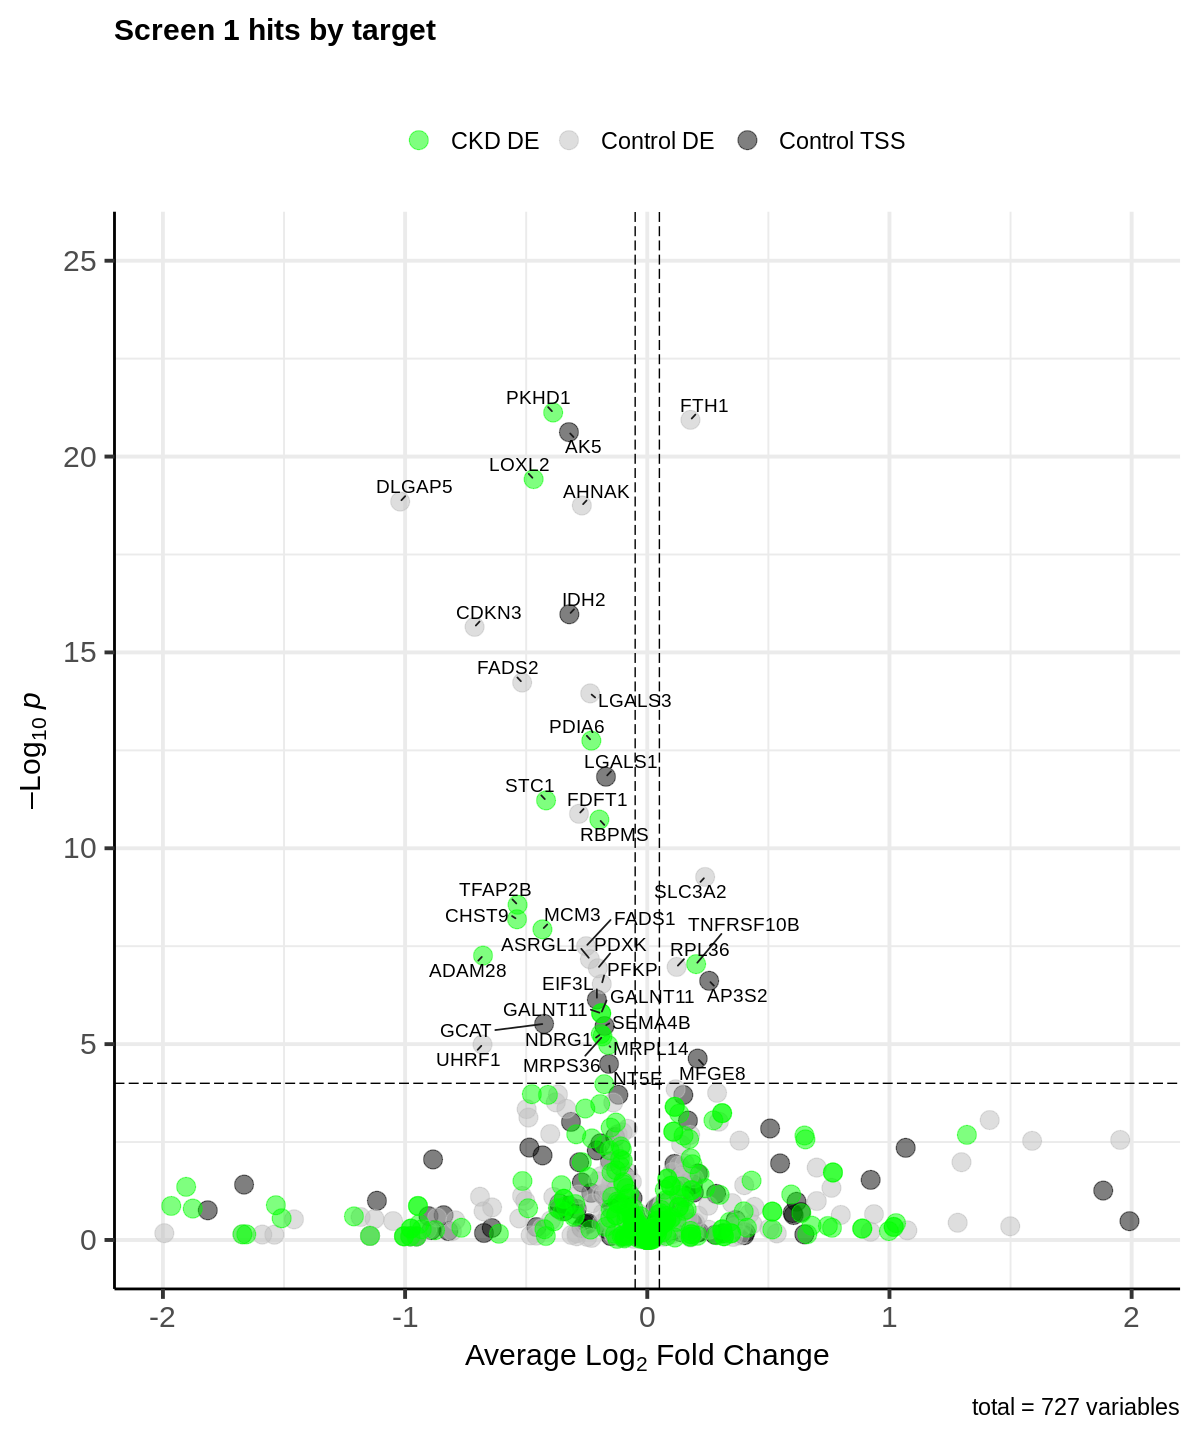

: 

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = '', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                ylim(0, 25) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

# Redundant

In [41]:
cluster_list = as.character(seurat_dummy$perturbation_status)
cluster_list[cluster_list == "guide_negative"] = 1
cluster_list[cluster_list == "guide_positive"] = 0
seurat_dummy$cluster = as.factor(cluster_list)
y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

In [42]:
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,6.5e+06,1,donor0,0
donor0_cluster1,1,1.6e+08,1,donor0,1
donor1_cluster0,1,7.4e+06,1,donor1,0
donor1_cluster1,1,1.7e+08,1,donor1,1
donor2_cluster0,1,1.1e+07,1,donor2,0
donor2_cluster1,1,2.2e+08,1,donor2,1
donor3_cluster0,1,7.5e+06,1,donor3,0
donor3_cluster1,1,1.7e+08,1,donor3,1


In [43]:
summary(y$samples$lib.size)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
6.52e+06 7.46e+06 8.73e+07 9.55e+07 1.74e+08 2.19e+08 

In [44]:
keep.samples <- y$samples$lib.size > 5e4
table(keep.samples)
y <- y[, keep.samples]

keep.samples
TRUE 
   8 

In [45]:
keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
table(keep.genes)

keep.genes
FALSE  TRUE 
14711 21891 

In [46]:
y <- normLibSizes(y)
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,6.5e+06,1.02,donor0,0
donor0_cluster1,1,1.6e+08,0.99,donor0,1
donor1_cluster0,1,7.4e+06,1.01,donor1,0
donor1_cluster1,1,1.7e+08,1.00,donor1,1
donor2_cluster0,1,1.1e+07,1.01,donor2,0
donor2_cluster1,1,2.2e+08,0.98,donor2,1
donor3_cluster0,1,7.5e+06,1.01,donor3,0
donor3_cluster1,1,1.7e+08,0.98,donor3,1


In [47]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.98    0.99    1.00    1.00    1.01    1.02 

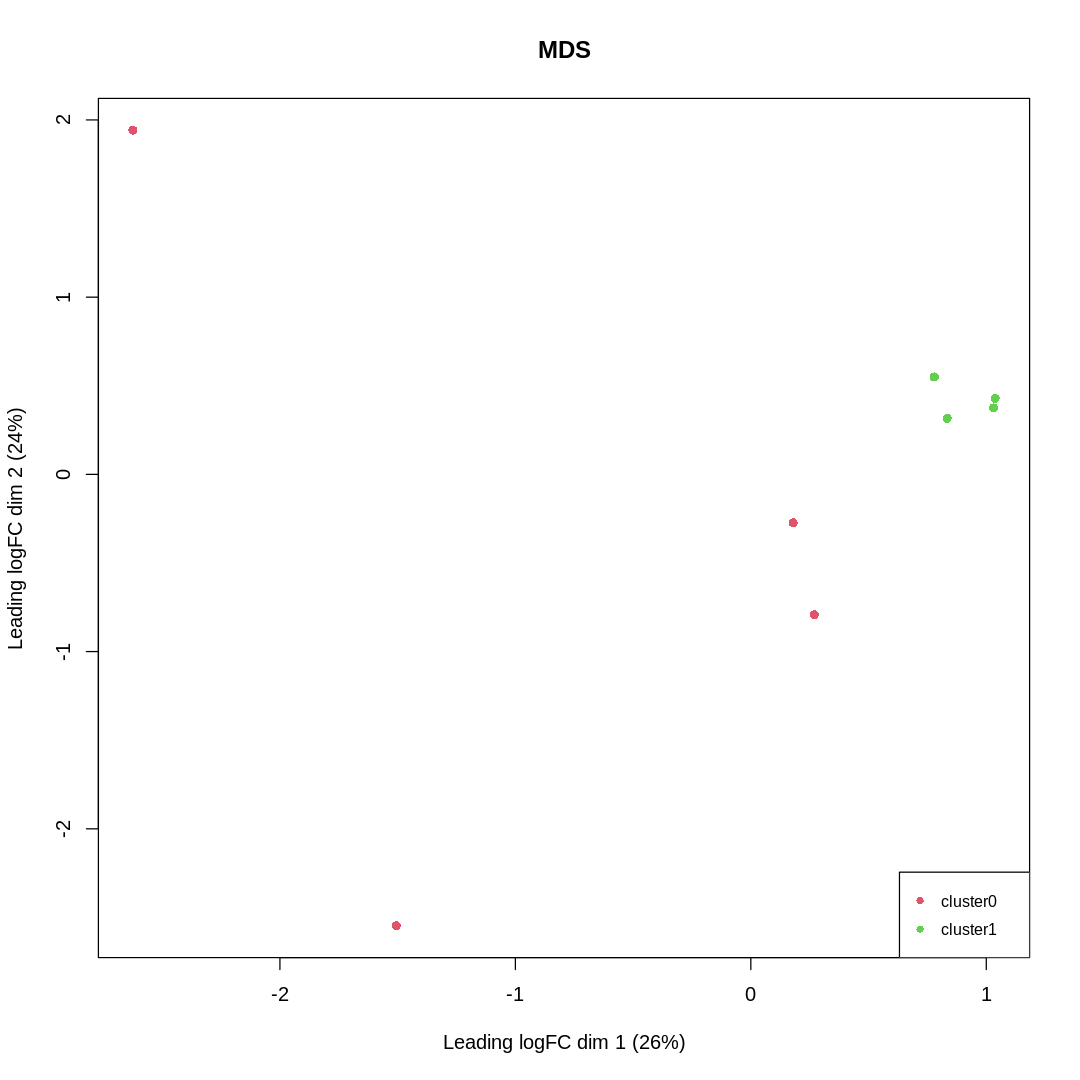

In [48]:
options(repr.plot.width=9, repr.plot.height=9)
cluster <- as.factor(y$samples$cluster)
plotMDS(y, pch=16, col=c(2:8)[cluster], main="MDS")
legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:8, cex=0.8)

In [49]:
donor <- factor(y$samples$sample)
design <- model.matrix(~ cluster + donor)
colnames(design) <- gsub("donor", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0


In [50]:
donor
cluster

[1] donor0 donor0 donor1 donor1 donor2 donor2 donor3 donor3
Levels: donor0 donor1 donor2 donor3

[1] 0 1 0 1 0 1 0 1
Levels: 0 1

[1] 0.0014

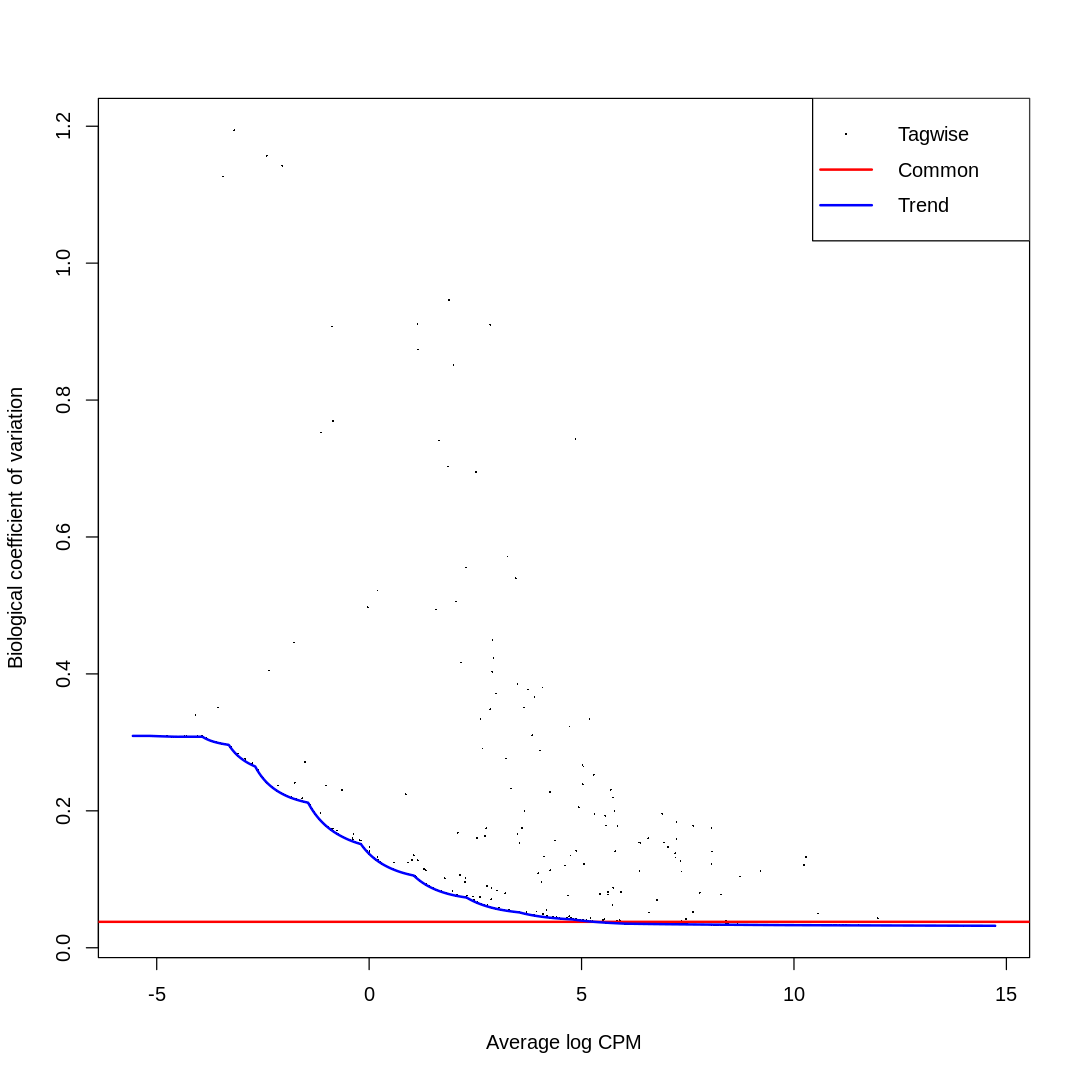

In [51]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

plotBCV(y)

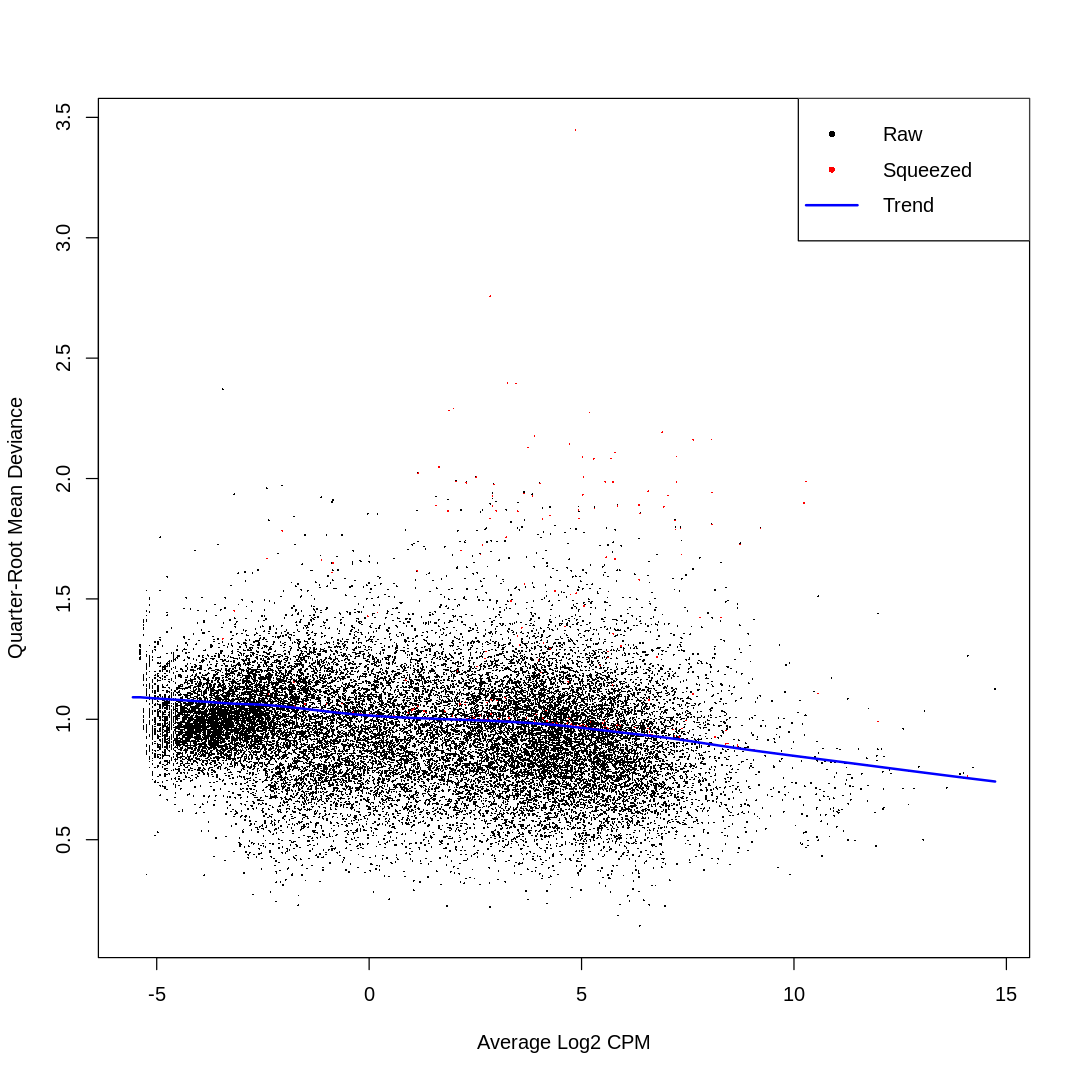

In [52]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

In [53]:
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

,cluster0,cluster1
Int,0,0
cluster1,-1,1
1,0,0
2,0,0
3,0,0


In [54]:
qlf <- list()
for(i in 1:ncls) {
    qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
    qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others") 
}

In [55]:
qlf[[1]]$table[neighbors, ] %>% arrange(PValue)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,-1.36879,6.906,1.2e+03,2.5e-226
IDH2,-0.32179,6.658,6.9e+01,1.1e-16
AP3S2,0.25549,5.387,2.7e+01,2.4e-07
SEMA4B,-0.17622,6.725,2.2e+01,3.5e-06
MFGE8,0.20813,5.432,1.8e+01,2.3e-05
CIB1,-0.11953,7.723,1.4e+01,2.0e-04
NGRN,0.14874,6.328,1.4e+01,2.0e-04
FANCI,-0.31513,3.494,1.1e+01,9.7e-04
BLM,-0.48703,1.861,8.1e+00,4.4e-03


In [56]:
dt <- lapply(lapply(qlf, decideTestsDGE), summary)
dt.all <- do.call("cbind", dt)
dt.all

,cluster0_vs_others,cluster1_vs_others
Down,2004,883
NotSig,33715,33715
Up,883,2004


In [57]:
top <- 20
topMarkers <- list()

for(i in 1:ncls) {
     ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
     up <- qlf[[i]]$table$logFC > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]] 
}

topMarkers <- unique(unlist(topMarkers))
topMarkers

[1] "ANPEP"      "dCas9"      "SQSTM1"     "ZIM3"       "TUBA1B"    
 [6] "GLS"        "GDF15"      "PTMA"       "SLCO4C1"    "NRXN3"     
[11] "STMN1"      "CDKN1A"     "FXYD2"      "MSC-AS1"    "HSP90B1"   
[16] "TNFRSF6B"   "LDHB"       "FNIP2"      "MKNK2"      "LINC02532" 
[21] "KRT19"      "AL138828.1" "OLAH"       "HMOX1"      "SERPINE2"  
[26] "MDM2"       "DDIT3"      "KRT18"      "S100A9"     "CDH6"      
[31] "KCNMB2-AS1" "PSAP"       "PLIN2"      "SFN"        "AC019197.1"
[36] "GDA"        "ABI3BP"     "ANXA4"      "CKB"        "ITPKA"

In [58]:
ncls

[1] 2

In [59]:
qlf[[1]]$table %>% filter(logFC < 0) %>% arrange(PValue)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,-1.37,6.9,1153,2.5e-226
KRT19,-0.74,8.3,590,8.6e-130
TUBA1B,-0.54,7.9,286,4.4e-64
SERPINE2,-0.39,10.1,248,9.4e-56
KRT18,-0.44,8.8,235,9.6e-53
GLS,-0.44,8.4,219,1.8e-49
S100A9,-2.38,3.0,219,2.1e-49
CDH6,-0.38,9.7,215,7.2e-48
PTMA,-0.36,10.0,203,4.1e-46


In [60]:
qlf[[1]]$table['ANPEP',]

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,-1.4,6.9,1153,2.5e-226


## Check using Seurat FindMarkers

In [61]:
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.1

markers <- FindMarkers(
    object = seurat_dummy,
    features = neighbors,
    slot = "data",
    ident.1 = 'guide_positive',
    ident.2 = 'guide_negative',
    test.use = test_use,
    logfc.threshold = logfc_threshold,
    latent.vars = c("library", "donor"),
    only.pos = FALSE, 
    verbose = FALSE
)


In [62]:
markers

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,1.9e-151,-0.64,0.46,0.78,6.8e-147
IDH2,9.2e-14,-0.14,0.78,0.83,3.4e-09
